In [ ]:
"""
I used code provided in the following resources to create these functions and classes:

Kumar, S. (2024) ‘Lecture-10-PER’.
Kumar, S. (2024) ‘Tutorial_9_DQN’.
Kumar, S. (2024) ‘Tutorial_10_PER’.
Raschka, S. and Mirjalili, V. (2017) Python machine learning: Machine learning and deep learning with python, scikit-learn, and tensorflow. Birmingham ; Mumbai: Packt Publishing.
Ravichandiran, S. (2018) Hands-on reinforcement learning with python: Master reinforcement and deep reinforcement learning using openai gym and tensorflow. Birmingham, UK: Packt Publishing.

I did not copy the code verbatim.
"""


In [ ]:
!pip install ipdb > /dev/null 2>&1
import ipdb

In [ ]:
!pip install gymnasium > /dev/null 2>&1
import gymnasium as gym

In [ ]:
!pip install imageio

In [ ]:
!pip install gymnasium[classic-control] > /dev/null 2>&1

In [ ]:
!pip install gym tensorflow keras


In [ ]:
import matplotlib.pyplot as plt

def plot_training_performance(log_file):
    # Read the log file
    episodes, rewards, avg_rewards, avg100_rewards = [], [], [], []

    with open(log_file, 'r') as file:
        for line in file:
            episode, reward, avg_reward, avg100_reward = map(float, line.split('\t'))
            episodes.append(episode)
            rewards.append(reward)
            avg_rewards.append(avg_reward)
            avg100_rewards.append(avg100_reward)

    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Episode vs Reward
    plt.subplot(1, 2, 1)
    plt.plot(episodes, rewards, label='Reward')
    plt.title('Episode vs Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)

    # Episode vs Average Reward
    plt.subplot(1, 2, 2)
    plt.plot(episodes, avg_rewards, label='Avg Reward', color='orange')
    plt.plot(episodes, avg100_rewards, label='Avg 100 Reward', color='green')
    plt.title('Episode vs Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import imageio
import numpy as np
from PIL import Image
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt

# Label a frame with the current episode and state
def _label_with_episode_number(frame, episode_num, step_num):
    im = Image.fromarray(frame) # Converting the frame
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128: # for dark image
        text_color = (255, 255, 255)
    else: #For bright image
        text_color = (0, 0, 0)
    #adding the text
    drawer.text((im.size[0]/20, im.size[1]/18),
          f'Episode: {episode_num+1}, Steps: {step_num+1}',
          fill=text_color)
    return im


In [ ]:
# Defining a function for valiate the agent
def validate(env, agent, wt_file: None):
    if wt_file is not None: # Loading the agent's weight
        agent.load_model(wt_file)

    max_steps = 200 #maximum step per episode
    frames = [] # For storing the frames
    scores = [] # For storing the scores

    for i in range(10): # Validate 10 episodes
        print('\r episode: ', i, end="") #Print the current episode
        sys.stdout.flush() #dispalying the output
        state = env.reset()[0] #Reseting the enironment
        state = np.expand_dims(state, axis=0) # Expand dimensions for compatibility
        step = 0 # Initialize step counter
        ep_reward = 0 # Initialize episodic reward

        while step < 200: # A loop for each step
            step += 1
            frame = env.render()
            frames.append(_label_with_episode_number(frame, i, step)) # Label and store frame
            action = agent.get_action(state, epsilon=0.001) # Get the agent's action using a small epsilon
            next_state, reward, done, _, _ = env.step(action) # Perform the action
            next_state = np.expand_dims(next_state, axis=0)
            state = next_state # Update the current state
            ep_reward += reward
            if done: #If the episode is done
                frame = env.render() # Render the final frame
                frames.append(_label_with_episode_number(frame, i, step)) # Label and store frame
                break
        #  Store the episodic reward
        scores.append(ep_reward)
    # for-loop ends here

    #Create a GIF
    gif_filename = f'{agent}_acro.gif'
    imageio.mimwrite(os.path.join('./', gif_filename), frames, duration=1000 / 60)
    print('\nAverage episodic score: ', np.mean(scores)) # Print the average score


# DQN and DDQN

In [ ]:
import numpy as np
class ReplayBuffer():
    "Buffer to store environment transitions"
    def __init__(self,capacity) -> None:
        self.capacity = capacity #Maximum number of experiences the buffer can store
        self.buffer = np.zeros(self.capacity, dtype=object)
        self.idx = 0 #For storing the next index
        self.last_save = 0
        self.full = False #Flag if the buffer is full

    def add(self, experience:tuple): #Function for adding the experience
        self.buffer[self.idx] = experience #store the experience
        self.idx = (self.idx + 1) % self.capacity #overwrite the the experience if the capacity is full
        self.full = self.full or self.idx == 0


    def sample(self, batch_size=24): #Sample a batach
        indices = np.random.randint(0, self.capacity if self.full else self.idx,
                                   size=batch_size) # generate random indices within the valid range of stored experience
        batch = self.buffer[indices] #create a random batch
        return batch

    def __getitem__(self, index):
      # Check if the index is within the valid range of stored experiences.
        if index >= 0 and index < self.capacity if self.full else self.idx:
          #If the index is valid, return the experience at that index
            return self.buffer[index]
        else:
          #If the index is out of range, raise a ValueError with a clear message.
            raise ValueError('Index is out of range')

    def __len__(self): #return the current number of stored experience
        return self.capacity if self.full else self.idx

In [ ]:
#Importing the libraries
import sys
import os
import random
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
import datetime

# Define a class for DQN and DDQN Algorithms
class DQNAgent:
    def __init__(self, obs_shape: tuple, n_actions: int,
                 buffer_size=2000, batch_size=32,
                 ddqn_flag=True, model=None):

        self.obs_shape = obs_shape  # shape: tuple
        self.action_size = n_actions  # number of discrete action state (int)
        self.ddqn = ddqn_flag  # Choose between DQN & DDQN

        # Hyperparameters for DQN
        self.gamma = 0.99  # Discount factor (high for long-term rewards)
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995  # Decay rate for epsilon
        self.epsilon_min = 0.01  # Minimum epsilon
        self.batch_size = batch_size  # Mini-batch size for training
        self.buffer_size = buffer_size  # Replay buffer size
        self.train_start = 1000  # Minimum buffer size to start training
        self.learning_rate = 0.001  # Smaller learning rate for stability

        # Create a replay buffer to store experiences
        self.memory = ReplayBuffer(self.buffer_size)

        # Create main model and target model
        if model is None:
            self.model = self._build_model() # Build a model if not provided
            if self.ddqn:
                self.target_model = self._build_model() # Target model for DDQN
        else:
            self.model = model # Using the provided model
            if self.ddqn: # Clone the provided model for DDQN
                self.target_model = tf.keras.models.clone_model(model)
        self.model.summary() # Display the model architecture

        # Initialize target model
        if self.ddqn:
            self.target_model.set_weights(self.model.get_weights())

    # Build the neural network
    def _build_model(self):
        model = keras.Sequential([
            keras.layers.Dense(64, input_shape=self.obs_shape, activation='relu',
                               kernel_initializer='he_uniform'),
            keras.layers.Dense(64, activation='relu',
                               kernel_initializer='he_uniform'),
            keras.layers.Dense(self.action_size, activation='linear',
                               kernel_initializer='he_uniform')
        ])
        # Compile the model
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # Update the target model weights using soft update
    def update_target_model(self, tau=0.01):
        if self.ddqn:  # Applicable only for Double DQN
            model_weights = self.model.get_weights()
            target_weights = self.target_model.get_weights()
            new_weights = [
                tau * mw + (1 - tau) * tw for mw, tw in zip(model_weights, target_weights)
            ]
            self.target_model.set_weights(new_weights)

    # Get action using epsilon-greedy policy
    def get_action(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon # Use the class's epsilon if not provided
        if np.random.rand() <= epsilon:  # Explore
            return random.randrange(self.action_size)
        else:  # Exploit
            q_value = self.model.predict(state, verbose=0)
            return np.argmax(q_value[0])

    # Store experience in the replay buffer
    def store_experience(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def get_target_q_value(self, next_states):  # Batch input
        q_values_ns = self.model.predict(next_states, verbose=0)  # Q(s',a')
        if self.ddqn:  # DDQN algorithm
            max_actions = np.argmax(q_values_ns, axis=1)
            target_q_values_ns = self.target_model.predict(next_states, verbose=0)
            max_q_values = target_q_values_ns[np.arange(len(target_q_values_ns)), max_actions]
        else:  # DQN
            max_q_values = np.amax(q_values_ns, axis=1)
        return max_q_values

    # Perform experience replay and update the model
    def experience_replay(self):
        # If there are not enough experiences to start training, skip
        if len(self.memory) < self.train_start:
            return

        # Sample a mini-batch from the replay buffer
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = self.memory.sample(batch_size)

        # Initialize arrays for states, next states, actions, rewards, and done flags
        states = np.zeros((batch_size, *self.obs_shape))
        next_states = np.zeros((batch_size, *self.obs_shape))
        actions, rewards, dones = [], [], []

        # Populate the arrays with values from the mini-batch
        for i, (state, action, reward, next_state, done) in enumerate(mini_batch):
            states[i] = state
            next_states[i] = next_state
            actions.append(action)
            rewards.append(reward)
            dones.append(done)

        # Predict Q-values for current states
        q_values = self.model.predict(states, verbose=0)
        max_q_values = self.get_target_q_value(next_states)

        # Update the Q-values based on the reward and next state values
        for i in range(batch_size):
            if dones[i]:
                q_values[i][actions[i]] = rewards[i] # The Q-value is just the reward
            else: # The Q-value is the reward plus the discounted future value
                q_values[i][actions[i]] = rewards[i] + self.gamma * max_q_values[i]

        # Fit the model on the updated Q-values
        self.model.fit(states, q_values, batch_size=batch_size, epochs=1, verbose=0)
        self.update_epsilon()  # # Update epsilon for exploration-exploitation tradeoff

    # Decay epsilon to reduce exploration over time
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # Save the trained model to a file
    def save_model(self, filename):
        self.model.save_weights(filename)

    # Load a pre-trained model from a file
    def load_model(self, filename):
        self.model.load_weights(filename)


In [ ]:
def train_acrobot(env, agent, max_episodes=300, train_freq=4, copy_freq=500, max_steps=500, log_interval=10, filename=None):
    # If a file name is provided, use the file
    if filename is not None:
        file = open(filename, 'w')

    tau = 0.1 if copy_freq < 10 else 1.0  # Soft updates for frequent copy_freq
    best_score = float('-inf') # Initialize the best score to a very low value
    scores = [] # For store a scores
    avg_score, avg100_score = [], [] # List to store avg_score and ayg100_score
    global_step_cnt = 0 # Global step counter for training and target model updates

    #Training loop
    for episode in range(max_episodes):
        state = env.reset()[0] #Reset the environment
        state = np.expand_dims(state, axis=0) ## Expand dimensions for compatibility
        done = False # Initialize the `done` flag
        ep_reward = 0 # For track the rewards
        step_count = 0 # Step counter

        # Episode Loop
        while not done and step_count < max_steps:
            global_step_cnt += 1 # increade it by one
            step_count += 1 # increade it by one

            # Take action
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)

            # Reward shaping for Acrobot
            reward = -1 if not done else 0  # Penalize for every step until done

            next_state = np.expand_dims(next_state, axis=0)

            # Store experience in replay buffer
            agent.store_experience(state, action, reward, next_state, done)

            state = next_state
            ep_reward += reward

            # Train the agent at intervals
            if global_step_cnt % train_freq == 0:
                agent.experience_replay()

            # Update target network periodically
            if global_step_cnt % copy_freq == 0:
                agent.update_target_model(tau=tau)

        # End of episode
        scores.append(ep_reward) ## Store the episodic reward
        avg_score.append(np.mean(scores)) # Compute and store the average score
        avg100_score.append(np.mean(scores[-100:])) # Compute and store the average of last 100 episodes

        # Save the best model
        if ep_reward > best_score:
            model_filename = f'{agent}_best_acrobot_model.weights.h5'
            agent.save_model(model_filename)
            best_score = ep_reward

        # Logging
        if filename is not None:
            file.write(f'{episode}\t{ep_reward}\t{np.mean(scores)}\t{np.mean(scores[-100:])}\n')
            file.flush()
            os.fsync(file.fileno())

        if episode % log_interval == 0:
            print(f'Episode: {episode}, Reward: {ep_reward}, Avg Reward: {np.mean(scores):.2f}, Best: {best_score}')

    print("Training completed.")
    if filename is not None:
        file.close()


In [ ]:
# Creating an Acrobot environment
env = gym.make("Acrobot-v1", render_mode='rgb_array')

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

# create DQN Agent
agent = DQNAgent(obs_shape, n_actions,
                buffer_size=2000,
                batch_size=32, ddqn_flag=False)
# train the agent
train_acrobot(env, agent, max_episodes=300, train_freq=4, copy_freq=500, max_steps=500, log_interval=10, filename='acro_dqn.txt')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,803 (18.76 KB)

 Trainable params: 4,803 (18.76 KB)

 Non-trainable params: 0 (0.00 B)

Episode: 0, Reward: -500, Avg Reward: -500.00, Best: -500
Episode: 10, Reward: -500, Avg Reward: -399.36, Best: -124
Episode: 20, Reward: -243, Avg Reward: -314.67, Best: -118
Episode: 30, Reward: -500, Avg Reward: -336.13, Best: -118
Episode: 40, Reward: -199, Avg Reward: -331.56, Best: -118
Episode: 50, Reward: -173, Avg Reward: -324.67, Best: -118
Episode: 60, Reward: -500, Avg Reward: -325.57, Best: -78
Episode: 70, Reward: -340, Avg Reward: -329.01, Best: -78
Episode: 80, Reward: -185, Avg Reward: -319.11, Best: -78
Episode: 90, Reward: -209, Avg Reward: -306.74, Best: -78
Episode: 100, Reward: -179, Avg Reward: -297.25, Best: -78
Episode: 110, Reward: -141, Avg Reward: -288.99, Best: -78
Episode: 120, Reward: -152, Avg Reward: -278.51, Best: -78
Episode: 130, Reward: -112, Avg Reward: -273.57, Best: -78
Episode: 140, Reward: -175, Avg Reward: -264.65, Best: -75
Episode: 150, Reward: -127, Avg Reward: -261.40, Best: -75
Episode: 160, Reward: -204, Avg Reward: -257.46, Best: -75
Ep

In [ ]:
# Validate the model
validate(env, agent, wt_file='agent_best_acrobot_model.weights.h5')

 episode:  9
Average episodic score:  -187.0


In [ ]:
# Create a GIF
import IPython
from IPython.display import Image
Image(filename='/content/agent_acro.gif')

Output hidden; open in https://colab.research.google.com to view.

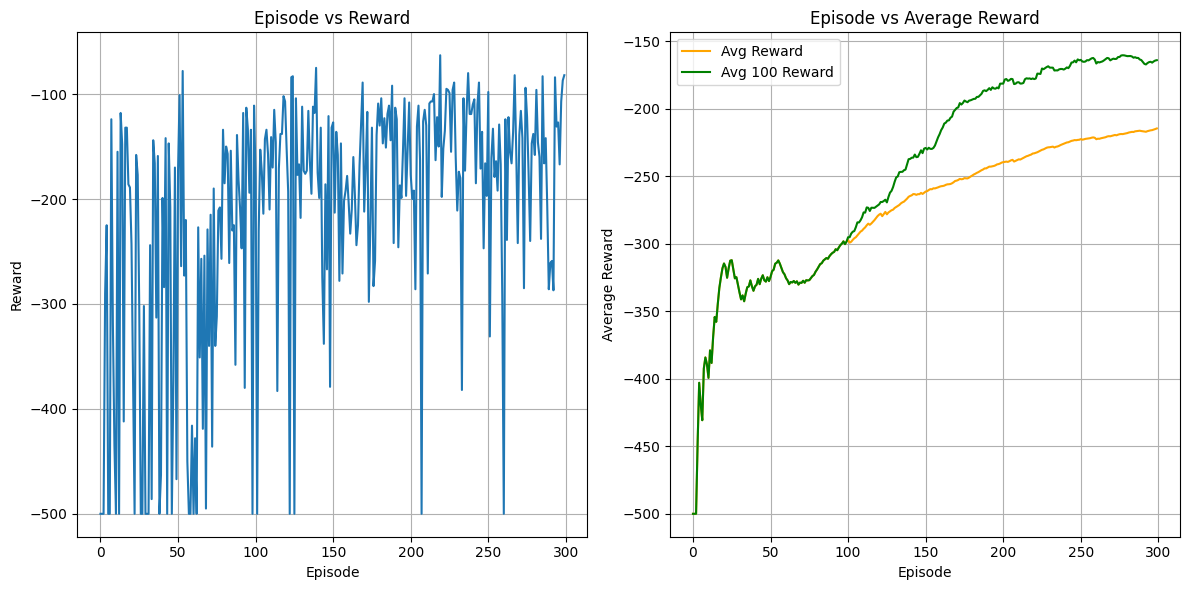

In [ ]:
#Plot the perfromance
plot_training_performance('acro_dqn.txt')

In [ ]:
# Create a DDQN agnet
agent_DDQN = DQNAgent(obs_shape, n_actions,
                buffer_size=2000,
                batch_size=32, ddqn_flag=True)
# train the agent
train_acrobot(env, agent_DDQN, max_episodes=300, train_freq=4, copy_freq=500, max_steps=500, log_interval=10, filename='acro_ddqn.txt')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,803 (18.76 KB)

 Trainable params: 4,803 (18.76 KB)

 Non-trainable params: 0 (0.00 B)

Episode: 0, Reward: -500, Avg Reward: -500.00, Best: -500
Episode: 10, Reward: -319, Avg Reward: -398.09, Best: -216
Episode: 20, Reward: -500, Avg Reward: -446.62, Best: -216
Episode: 30, Reward: -305, Avg Reward: -431.06, Best: -216
Episode: 40, Reward: -157, Avg Reward: -397.80, Best: -109
Episode: 50, Reward: -176, Avg Reward: -371.16, Best: -109
Episode: 60, Reward: -301, Avg Reward: -360.93, Best: -109
Episode: 70, Reward: -134, Avg Reward: -344.66, Best: -109
Episode: 80, Reward: -177, Avg Reward: -324.09, Best: -109
Episode: 90, Reward: -158, Avg Reward: -304.91, Best: -109
Episode: 100, Reward: -115, Avg Reward: -286.66, Best: -93
Episode: 110, Reward: -89, Avg Reward: -270.29, Best: -73
Episode: 120, Reward: -141, Avg Reward: -258.35, Best: -73
Episode: 130, Reward: -113, Avg Reward: -248.81, Best: -73
Episode: 140, Reward: -88, Avg Reward: -239.33, Best: -73
Episode: 150, Reward: -94, Avg Reward: -230.19, Best: -73
Episode: 160, Reward: -198, Avg Reward: -224.50, Best: -73
E

In [ ]:
# Validate DDQN agent
validate(env, agent_DDQN, wt_file='agent_DDQN_best_acrobot_model.weights.h5')

 episode:  9
Average episodic score:  -105.8


In [ ]:
#Create a DDQN GIF
import IPython
from IPython.display import Image
Image(filename='/content/agent_DDQN_acro.gif')

Output hidden; open in https://colab.research.google.com to view.

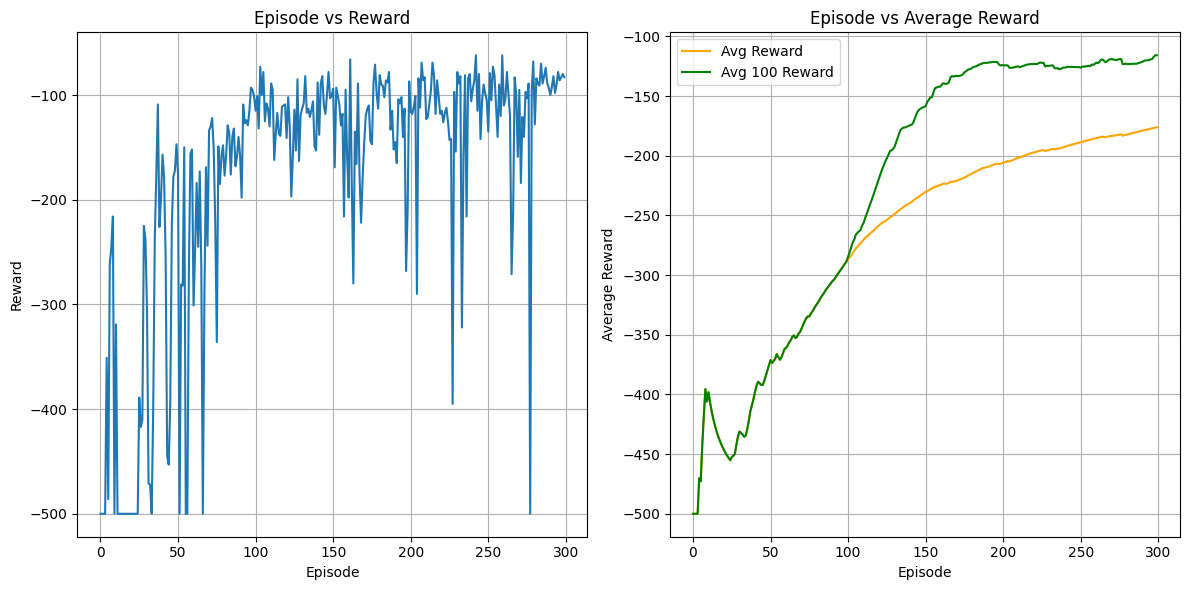

In [ ]:
# Plot DDQN performance
plot_training_performance('acro_ddqn.txt')

# Prioritized Experience Replay

In [ ]:
class SumTree(object):
    def __init__(self, capacity):
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        self.data_pointer = 0
        self.full = False   # indicates if the buffer is full
        self.tree = np.zeros(2 * capacity - 1)  # contains priorities

        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)

    def add(self, priority, data):
        # data is stored at the leaf of the tree from index: n-1 to 2*n-1
        tree_index = self.data_pointer + self.capacity - 1

        # Update data frame
        self.data[self.data_pointer] = data

        # Update the leaf
        self.update(tree_index, priority)

        # Add 1 to data_pointer
        self.data_pointer += 1
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0
            self.full = True

    def __len__(self):  # returns the size of data buffer only
        return self.capacity if self.full else self.data_pointer

    def __getitem__(self, index):
        # return data and priority at index i
        if index >= 0 and index < self.capacity \
                    if self.full else self.data_pointer:
            tree_idx = index + self.capacity - 1
            return self.data[index], self.tree[tree_idx]
        else:
            raise ValueError('index out of range')


    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # then propagate the change through tree
        # this method is faster than the recursive loop
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    def get_leaf(self, v):
        parent_index = 0

        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else: # downward search, always search for a higher priority node
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]

    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node


In [ ]:
class STBuffer(object):
    # stored as ( state, action, reward, next_state ) in SumTree
    PER_e = 0.01  #it used to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  #it used to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1

    PER_b_increment_per_sampling = 0.001

    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree
        self.tree = SumTree(capacity)

    def add(self, experience):
        # Find the max priority of leaf nodes
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(max_priority, experience)   # set the priority for new experience

    def sample(self, n):
        # Create a minibatch array that will contains the minibatch
        minibatch = []
        b_idx = np.empty((n,), dtype=np.int32)

        # Calculate the priority segment
        # it divided the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n  # priority segment

        for i in range(n):
            # A value is uniformly sample from each range
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)

            # Experience that correspond to each value is retrieved
            index, priority, data = self.tree.get_leaf(value)
            b_idx[i]= index
            minibatch.append([data[0],data[1],data[2],data[3],data[4]])

        return b_idx, minibatch,

    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)

        # stochastic prioritization
        ps = np.power(clipped_errors, self.PER_a)  # values between 0 and 1

        # convert priorities into probabilities
        prob = ps / np.sum(ps) # experimental

        # importance sampling weights: iw = [1 / ( N * P)]^b
        is_wts = np.power(len(prob) * prob, -self.PER_b) # experimental

        for ti, p, iw in zip(tree_idx, ps, is_wts):
            new_p = p * iw
            self.tree.update(ti, new_p)

        # gradually increase PER_b for more focus on high-error experience
        self.PER_b = min(1.0, self.PER_b + self.PER_b_increment_per_sampling)


    def __len__(self):
        return len(self.tree)

    def __getitem__(self, index):
        return self.tree[index]

In [ ]:
class DQNPERAgent(DQNAgent):
    def __init__(self, obs_shape: tuple, n_actions: int,
                        buffer_size=2000, batch_size=24,
                        ddqn_flag=True, model=None):
        # Call the parent class DQNAgent
        super().__init__(obs_shape, n_actions, buffer_size,
                        batch_size, ddqn_flag, model)

        # uses a sumtree Buffer
        self.memory = STBuffer(capacity=buffer_size)

    # Override the experience_replay method to implement PER
    def experience_replay(self):
        if len(self.memory) < self.train_start:
            return

        # Sample a batch of experiences from memory using PER
        batch_size = min(self.batch_size, len(self.memory))
        tree_idx, mini_batch = self.memory.sample(self.batch_size)

        # Initialize placeholders for batch processing
        states = np.zeros((self.batch_size, *self.obs_shape))
        next_states = np.zeros((self.batch_size, *self.obs_shape))
        actions = np.zeros((self.batch_size, 1))
        rewards = np.zeros((self.batch_size, 1))
        dones = np.zeros((self.batch_size, 1))

        for i in range(len(mini_batch)):
            states[i] = mini_batch[i][0] # current state
            actions[i] = mini_batch[i][1] # Action taken
            rewards[i] = mini_batch[i][2] # Reward recieved
            next_states[i] = mini_batch[i][3] # Next State
            dones[i]  = mini_batch[i][4] # Done flag

        q_values_cs = self.model.predict(states, verbose=0)
        q_values_cs_old = np.array(q_values_cs).copy() # deep copy
        max_q_values_ns = self.get_target_q_value(next_states)


        for i in range(len(q_values_cs)):
            action = actions[i].astype(int)[0] # check
            done = dones[i].astype(bool)[0] # check
            reward = rewards[i][0] # check
            if done:
                q_values_cs[i][action] = reward
            else:
                q_values_cs[i][action] = reward + self.gamma * max_q_values_ns[i]

        # update experience priorities
        indices = np.arange(self.batch_size, dtype=np.int32)
        actions = actions[:,0].astype(int)
        absolute_errors = np.abs(q_values_cs_old[indices, actions] - \
                                q_values_cs[indices, actions])
        # update sample priorities
        self.memory.batch_update(tree_idx, absolute_errors)

        # train the Q network
        self.model.fit(np.array(states),
                    np.array(q_values_cs),
                    batch_size = batch_size,
                    epochs = 1,
                    verbose = 0)

        # decay epsilon over time
        self.update_epsilon()


In [ ]:
# Create a DQN with PER agent
agent_DQNPER = DQNPERAgent(obs_shape, n_actions,
                buffer_size=2000,
                batch_size=32, ddqn_flag=False)
# train the agent
train_acrobot(env, agent_DQNPER, max_episodes=300, train_freq=4, copy_freq=500, max_steps=500, log_interval=5, filename='acro_dqn_per.txt')


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,803 (18.76 KB)

 Trainable params: 4,803 (18.76 KB)

 Non-trainable params: 0 (0.00 B)

Episode: 0, Reward: -500, Avg Reward: -500.00, Best: -500
Episode: 5, Reward: -334, Avg Reward: -422.67, Best: -202
Episode: 10, Reward: -139, Avg Reward: -367.09, Best: -139
Episode: 15, Reward: -420, Avg Reward: -382.38, Best: -139
Episode: 20, Reward: -299, Avg Reward: -395.48, Best: -139
Episode: 25, Reward: -201, Avg Reward: -371.19, Best: -139
Episode: 30, Reward: -134, Avg Reward: -334.42, Best: -104
Episode: 35, Reward: -148, Avg Reward: -317.03, Best: -104
Episode: 40, Reward: -133, Avg Reward: -298.98, Best: -104
Episode: 45, Reward: -176, Avg Reward: -283.39, Best: -98
Episode: 50, Reward: -355, Avg Reward: -283.27, Best: -98
Episode: 55, Reward: -200, Avg Reward: -271.73, Best: -98
Episode: 60, Reward: -179, Avg Reward: -261.18, Best: -98
Episode: 65, Reward: -164, Avg Reward: -255.92, Best: -98
Episode: 70, Reward: -219, Avg Reward: -249.58, Best: -98
Episode: 75, Reward: -342, Avg Reward: -249.01, Best: -98
Episode: 80, Reward: -86, Avg Reward: -239.05, Best: -80
Episode:

In [ ]:
# Validate DQN with PER agent
validate(env, agent_DQNPER, wt_file='agent_DQN_PER_best_acrobot_model.weights.h5')

 episode:  9
Average episodic score:  -85.2


In [ ]:
# Create the DQN with PER GIF
import IPython
from IPython.display import Image
Image(filename='/content/agent_DQN_PER_acro.gif')

Output hidden; open in https://colab.research.google.com to view.

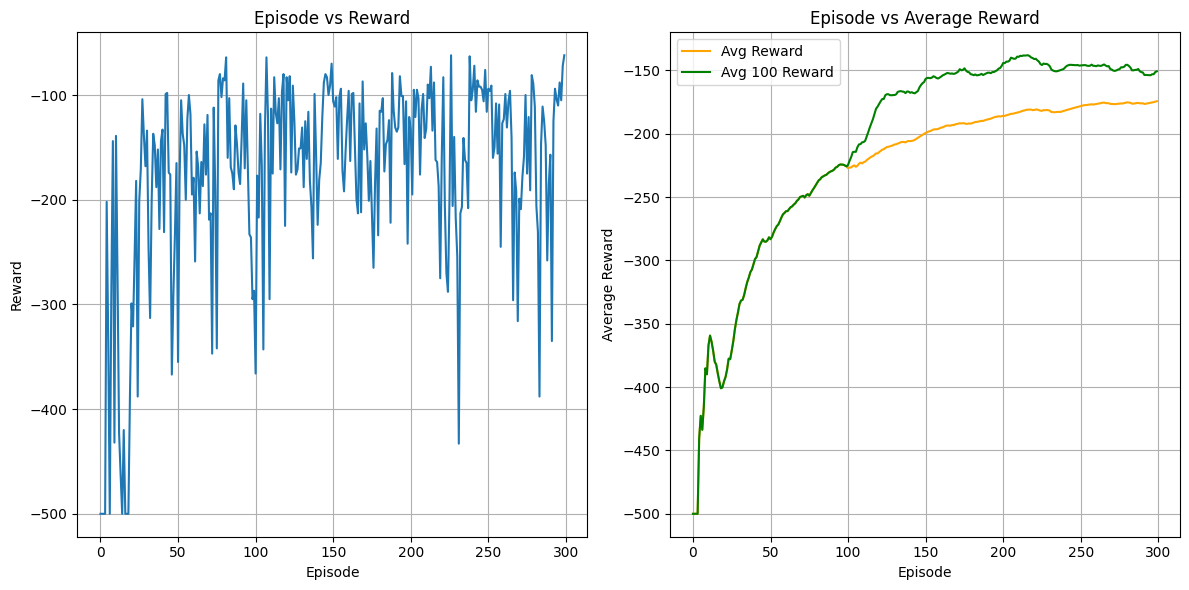

In [ ]:
#PLot DQN with PER performance
plot_training_performance('acro_dqn_per.txt')

In [ ]:
# Create DDQN with PER agent
agent_DDQNPER = DQNPERAgent(obs_shape, n_actions,
                buffer_size=2000,
                batch_size=32, ddqn_flag=True)
# train the agent
train_acrobot(env, agent_DDQNPER, max_episodes=300, train_freq=4, copy_freq=500, max_steps=500, log_interval=5, filename='acro_ddqn_per.txt')


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,803 (18.76 KB)

 Trainable params: 4,803 (18.76 KB)

 Non-trainable params: 0 (0.00 B)

Episode: 0, Reward: -500, Avg Reward: -500.00, Best: -500
Episode: 5, Reward: -500, Avg Reward: -500.00, Best: -500
Episode: 10, Reward: -209, Avg Reward: -408.82, Best: -166
Episode: 15, Reward: -500, Avg Reward: -378.81, Best: -162
Episode: 20, Reward: -500, Avg Reward: -392.86, Best: -162
Episode: 25, Reward: -500, Avg Reward: -413.46, Best: -162
Episode: 30, Reward: -471, Avg Reward: -420.03, Best: -162
Episode: 35, Reward: -349, Avg Reward: -413.47, Best: -162
Episode: 40, Reward: -405, Avg Reward: -408.66, Best: -162
Episode: 45, Reward: -165, Avg Reward: -395.35, Best: -162
Episode: 50, Reward: -500, Avg Reward: -399.86, Best: -162
Episode: 55, Reward: -500, Avg Reward: -408.80, Best: -162
Episode: 60, Reward: -252, Avg Reward: -401.56, Best: -162
Episode: 65, Reward: -172, Avg Reward: -387.79, Best: -162
Episode: 70, Reward: -223, Avg Reward: -378.73, Best: -162
Episode: 75, Reward: -224, Avg Reward: -377.05, Best: -162
Episode: 80, Reward: -259, Avg Reward: -369.31, Best: -162

In [ ]:
#Validate agent_DDQNPER
validate(env, agent_DDQNPER, wt_file='agent_DDQN_PER_best_acrobot_model.weights.h5')

 episode:  9
Average episodic score:  -200.0


In [ ]:
# Create a DDQN with PER GIF
import IPython
from IPython.display import Image
Image(filename='/content/agent_DDQN_PER_acro.gif')

Output hidden; open in https://colab.research.google.com to view.

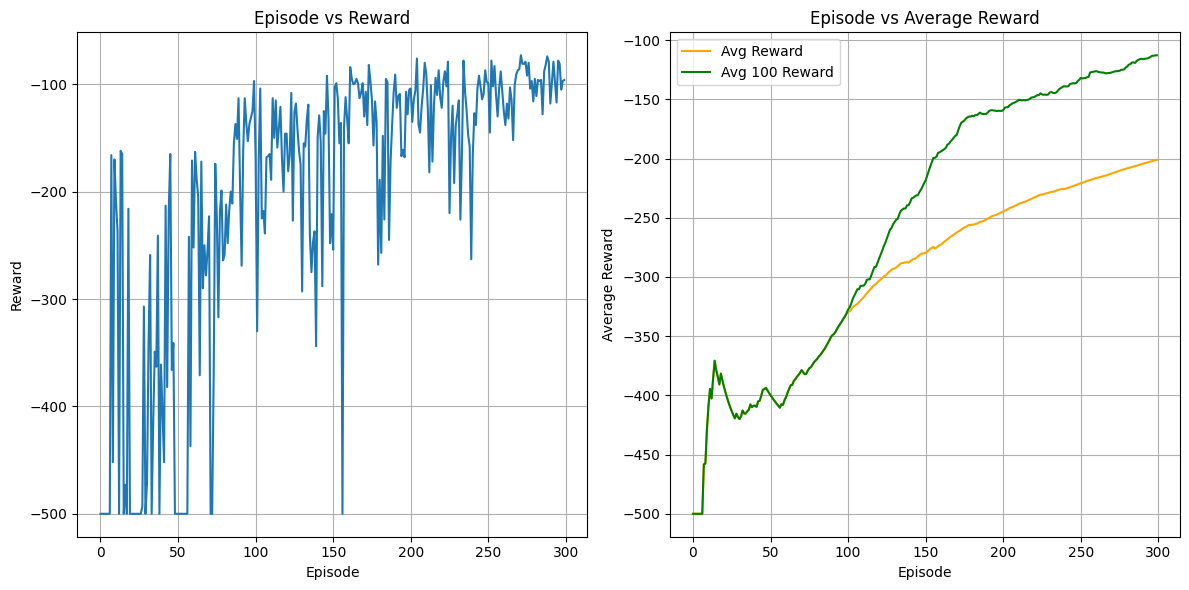

In [ ]:
# Plot the DDQN with PER perfromance
plot_training_performance('acro_ddqn_per.txt')

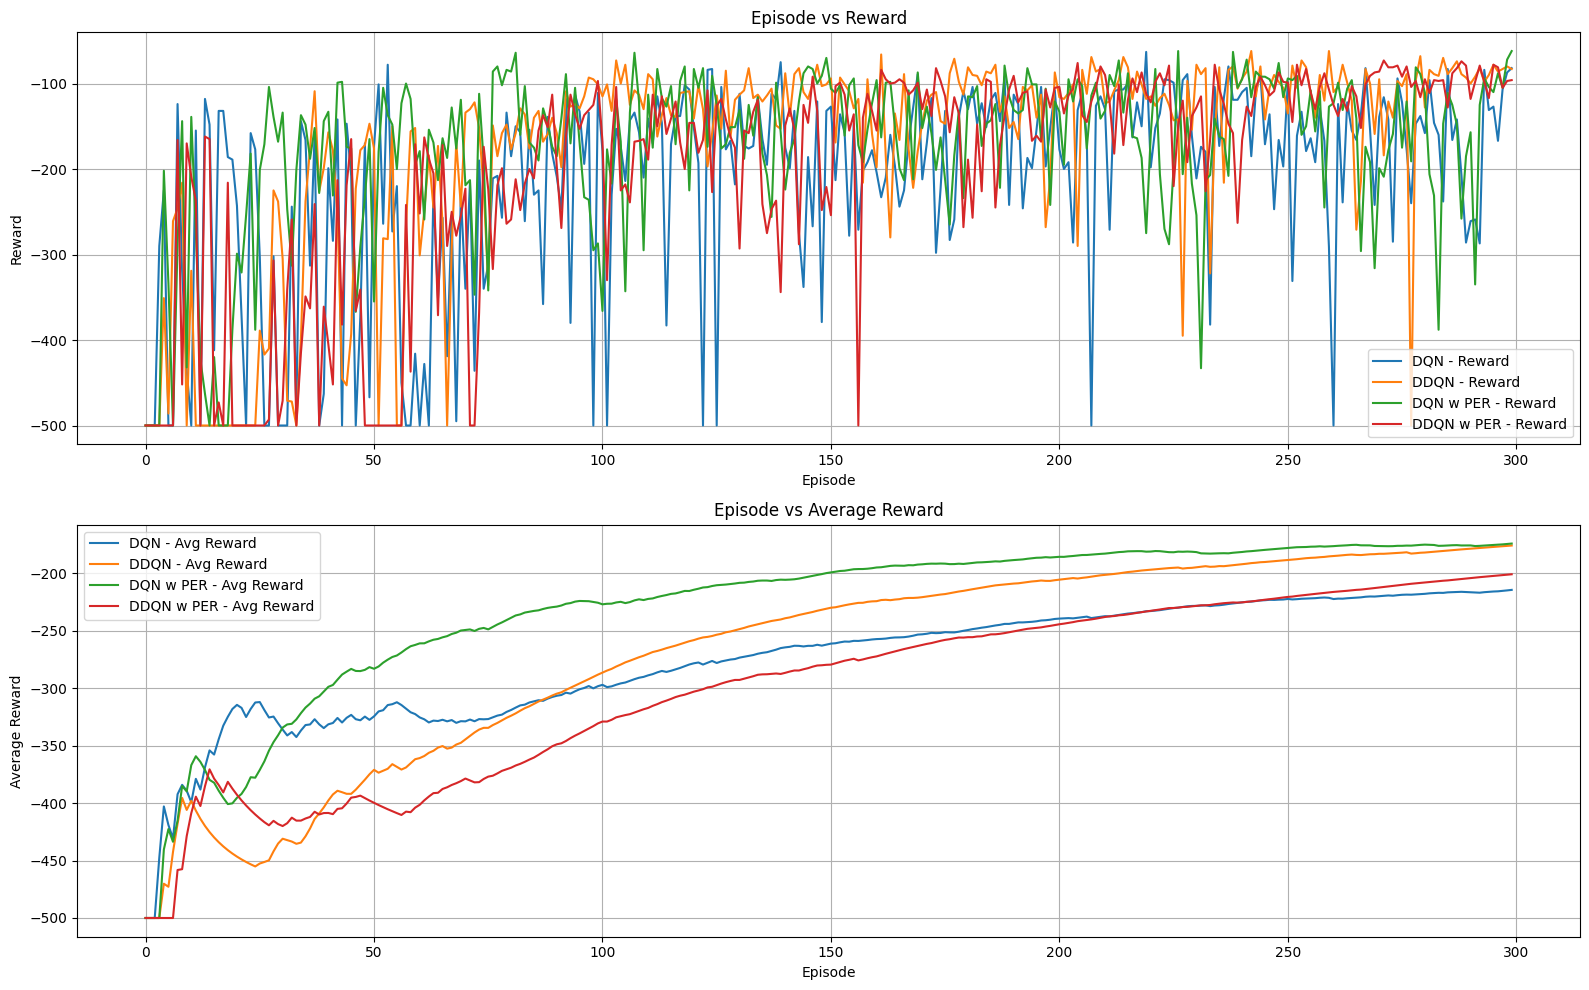

In [ ]:
import matplotlib.pyplot as plt

# Paths to the log files
log_files = [
    'acro_dqn.txt',
    'acro_ddqn.txt',
    'acro_dqn_per.txt',
    'acro_ddqn_per.txt'
]

# Corresponding model names
model_names = ['DQN', 'DDQN', 'DQN w PER', 'DDQN w PER']

# Initialize lists to hold data for plotting
all_episodes = []
all_rewards = []
all_avg_rewards = []
all_avg100_rewards = []

# Read data from each log file
for log_file in log_files:
    episodes, rewards, avg_rewards, avg100_rewards = [], [], [], []
    with open(log_file, 'r') as file:
        for line in file:
            episode, reward, avg_reward, avg100_reward = map(float, line.split('\t'))
            episodes.append(episode)
            rewards.append(reward)
            avg_rewards.append(avg_reward)
            avg100_rewards.append(avg100_reward)
    all_episodes.append(episodes)
    all_rewards.append(rewards)
    all_avg_rewards.append(avg_rewards)
    all_avg100_rewards.append(avg100_rewards)

# Plotting
plt.figure(figsize=(16, 10))  # Wider and taller figure for better visualization

# Plot 1: Episode vs Reward
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
for episodes, rewards, model_name in zip(all_episodes, all_rewards, model_names):
    plt.plot(episodes, rewards, label=f'{model_name} - Reward')
plt.title('Episode vs Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)

# Plot 2: Episode vs Average Reward
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd plot
for episodes, avg_rewards, model_name in zip(all_episodes, all_avg_rewards, model_names):
    plt.plot(episodes, avg_rewards, label=f'{model_name} - Avg Reward', linestyle='-')
plt.title('Episode vs Average Reward')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
